In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/thesis

Mounted at /content/drive
/content/drive/MyDrive/thesis


In [ ]:
!pip install torch_dct

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
import cv2
import cupy as cp
import os
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

Data Pre-Processing:

In [ ]:
wm_val = torch.load('/content/drive/MyDrive/thesis/watermark_tensors/watermark_val_tensor', weights_only=True)/255

Model Building and Design:

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1,
                               kernel_size=(5,5), stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)

        self.trans1 = nn.ConvTranspose2d(in_channels=1, out_channels=1,
                            kernel_size=(2,2), stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x, watermark):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        # Watermark Embedding
        x = dct.dct_2d(x)
        x = x + watermark
        x = dct.idct_2d(x)

        x = self.relu(self.trans1(x))

        return x

Building Loop:

In [ ]:
class DeclareDataset(Dataset):

    def __init__(self, video_frames, watermark_frames, conv_video=None):
        self.video = video_frames
        self.watermark = watermark_frames
        self.conv = conv_video

    def __getitem__(self, idx):
        watermark = self.watermark[idx]
        video = self.video[idx]

        if self.conv is not None:
          conv = self.conv[idx]
          return video, watermark, conv

        return video, watermark

    def __len__(self):
        return len(self.video)

In [ ]:
def train_cnn(train_dataloader, test_dataloader, model, loss_fn, optimizer, pretrained_model=False):
    model = model.to(device)

    out = directory1
    if not os.path.isdir(out):
        os.makedirs(out)

    out2 = directory2
    if not os.path.isdir(out2):
        os.makedirs(out2)

    path = f"{out}/MLP1L.pt"

    if resume0 == True:

        if pretrained_model == False:
          log = open(os.path.join(out,'epoch_log.txt'),'a+')

          training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
          testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))

        else:
          log = open(os.path.join(out, 'epoch_log.txt'), 'w+')
          log = open(os.path.join(out, 'epoch_log.txt'), 'a+')

          training_loss1 = []
          testing_loss1 = []

        saved_model = torch.load(path, weights_only=True)
        model.load_state_dict(saved_model['model_state_dict'])
        optimizer.load_state_dict(saved_model['optimizer_state_dict'])

    elif resume0 == False:
        log = open(os.path.join(out, 'epoch_log.txt'), 'w+')
        log = open(os.path.join(out, 'epoch_log.txt'), 'a+')

        training_loss1 = []
        testing_loss1 = []

    test_count = len(test_dataloader)

    time_start = time.time()

    train_count = 0

    epoch = len(training_loss1)

    while (epoch < max_epoch):
        size = len(train_dataloader.dataset)
        num_train_batches = len(train_dataloader)

        model.train()

        train_loss = 0.
        for batch, (video, watermark) in enumerate(train_dataloader):

            pred = model(video, watermark)

            loss = loss_fn(pred, video)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        training_loss1.append(train_loss/num_train_batches)

        model.eval()
        size = len(test_dataloader.dataset)
        num_test_batches = len(test_dataloader)
        test_loss = 0.

        with torch.no_grad():
            for video, watermark in test_dataloader:
                pred = model(video, watermark)

                test_loss += loss_fn(pred, video).item()

        testing_loss1.append(test_loss/num_test_batches)

        epoch = len(testing_loss1)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss/num_test_batches
        }, path)

        pickle.dump(training_loss1,open(os.path.join(out,"training_loss1.pkl"),"wb"))

        pickle.dump(testing_loss1,open(os.path.join(out,"testing_loss1.pkl"),"wb"))

        time_epoch = time.time() - time_start
        log.write(f'\n Epoch:{epoch:06d} Time elapsed:{time_epoch:0.06f} sec')

        log.flush()
        print(f'Epoch:{epoch:06d} done. Training Loss: {training_loss1[-1]*100:0.02f}. Testing Loss: {testing_loss1[-1]*100:0.02f}')

        if epoch%save_epoch == 0:
            out3 = f'epoch{epoch:06d}'
            if not os.path.isdir(os.path.join(out2, out3)):
                os.mkdir(os.path.join(out2, out3))

            import shutil
            shutil.copy(os.path.join(out,'MLP1L.pt'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'testing_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'training_loss1.pkl'),os.path.join(out2,out3))
            shutil.copy(os.path.join(out,'epoch_log.txt'),os.path.join(out2,out3))

In [ ]:
def graph_loss(file_name, save_fig=False):
    training_loss1 = pickle.load(open(os.path.join(out,"training_loss1.pkl"),"rb"))
    testing_loss1 = pickle.load(open(os.path.join(out,"testing_loss1.pkl"),"rb"))

    print(f'Batchsize:{batchsize}')
    print(f'last epoch: {len(training_loss1)}')
    print(f'Training Loss: {training_loss1[-1]*100:0.02f}')
    print(f'Testing Loss: {testing_loss1[-1]*100:0.02f}')

    #Convert to CuPy arrays and then to NumPy arrays
    training_loss1 = cp.array(training_loss1).get()
    testing_loss1 = cp.array(testing_loss1).get()

    fig = plt.figure(figsize=(12, 6), dpi=300)
    test = plt.plot(testing_loss1,'red', label='Testing Loss')
    train = plt.plot(training_loss1,'blue', label ='Training Loss')
    plt.title(f'{file_name} Loss',fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    # Set x-axis ticks at intervals of 100
    tick_positions = range(0, len(testing_loss1)+1, 100)
    plt.xticks(tick_positions, fontsize=14)

    # Set x-axis tick labels at intervals of 200
    tick_labels = [str(i) if i % 400 == 0 else '' for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, fontsize=14)

    plt.yticks(np.linspace(0, 0.2, 5), fontsize=14)

    plt.ylim(0,0.2)
    # Set x-axis limits to ensure 0 is not offset
    plt.xlim(0, len(testing_loss1))

    plt.grid(True)
    plt.legend(fontsize=14)
    if save_fig:
        plt.savefig(f'{file_name}_loss.png')

    plt.show()

Model Training and Validation:

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [ ]:
names = ["bluesky", "crosswalk", "crowd1", "dinner", "ducks2", "factory1", "factory2", "field1", "field2", "intotree1", "intotree2", "kayak1", "kayak2", "life2", "life3",
         "market", "oldtown", "parkjoy1", "parkjoy2", "pedestrian1", "riverbed1", "riverbed2", "rush2", "sintel1", "sintel2", "snow", "speedbag1", "speedbag2",
         "sunflower2", "touchdown1", "touchdown2", "wind"]
#names = ["bluesky"]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
del train_dataloader, test_dataloader

In [ ]:
for idx, name in enumerate(names):

  torch.cuda.empty_cache()

  in_val = torch.load(f'/content/drive/Shareddrives/thesis_0418 training_val/{name}_val_tensor', weights_only=True)/255

  curriculum = 1

  train_video, test_video, train_watermark, test_watermark = train_test_split(in_val, wm_val, test_size=0.1, random_state=1)

  train_video = train_video.to(device)
  train_watermark = train_watermark.to(device)

  test_video = test_video.to(device)
  test_watermark = test_watermark.to(device)

  train_dataset = DeclareDataset(train_video, train_watermark)
  test_dataset = DeclareDataset(test_video, test_watermark)

  del train_video, train_watermark, test_video, test_watermark

  batchsize = 32

  train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

  del train_dataset, test_dataset

  # Set maximum epoch of the full training
  max_epoch = 825 + idx*25

  model = Autoencoder()

  learning_rate = 1e-3

  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  resume0 = True
  # Set resume0 to False if starting from 0 epochs
  # Set resume0 to True if otherwise

  resume1 = False
  # Set resume1 to False to continue using main directory
  # Set resume1 to True to resume using snapshot directory

  resume2 = False

  # Which last epoch would you like to continue? Change if resume1 is True
  last_epoch = max_epoch - 100

  # Save model and state every save_epoch
  save_epoch = 50

  # Continuous training directory
  directory1 = f'0419_{curriculum:02d}_full'
  # Snapshot directory (Save models every save_epoch)
  directory2 = f'0419_{curriculum:02d}_snapshot'

  prev_curr = curriculum
  if curriculum > 1:
      prev_curr = curriculum-1

  out = directory1
  if not os.path.isdir(out):
      os.makedirs(out)

  out2 = directory2
  if not os.path.isdir(out2):
      os.makedirs(out2)

  # Present curriculum directory
  if resume1 == True and resume2 == False:
      directory3 = directory2
  # Previous curriculum directory
  if resume1 == True and resume2 == True:
      directory3 = f'0419_{prev_curr:02d}_snapshot'


  if resume1 == True:
      import shutil
      shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
      shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
      shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
      shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

  train_cnn(train_dataloader, test_dataloader, model, loss_fn, optimizer, pretrained_model=False)
  print(f"{name} done")

Epoch:000801 done. Training Loss: 0.37. Testing Loss: 0.37
Epoch:000802 done. Training Loss: 0.35. Testing Loss: 0.34
Epoch:000803 done. Training Loss: 0.34. Testing Loss: 0.33
Epoch:000804 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000805 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000806 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000807 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000808 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000809 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000810 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000811 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000812 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000813 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000814 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000815 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000816 done. Training Loss: 0.33. Testing Loss: 0.33
Epoch:000817 done. Training Loss: 0.33. Testing Loss: 0.

In [ ]:
curriculum=1
# Set maximum epoch of the full training
# Max_epoch = 825 + idx*25

model = Autoencoder()

learning_rate = 1e-3

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

resume0 = True
# Set resume0 to False if starting from 0 epochs
# Set resume0 to True if otherwise

resume1 = False
# Set resume1 to False to continue using main directory
# Set resume1 to True to resume using snapshot directory

resume2 = False


# Save model and state every save_epoch
save_epoch = 50

# Continuous training directory
directory1 = f'0419_{curriculum:02d}_full'
# Snapshot directory (Save models every save_epoch)
directory2 = f'0419_{curriculum:02d}_snapshot'

prev_curr = curriculum
if curriculum > 1:
    prev_curr = curriculum-1

out = directory1
if not os.path.isdir(out):
    os.makedirs(out)

out2 = directory2
if not os.path.isdir(out2):
    os.makedirs(out2)

#present curriculum directory
if resume1 == True and resume2 == False:
    directory3 = directory2
#previous curriculum directory
if resume1 == True and resume2 == True:
    directory3 = f'0419_{prev_curr:02d}_snapshot'


if resume1 == True:
    import shutil
    shutil.copy(os.path.join(directory3,'epoch{:06d}//MLP1L.pt'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//testing_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//training_loss1.pkl'.format(last_epoch)),directory1)
    shutil.copy(os.path.join(directory3,'epoch{:06d}//epoch_log.txt'.format(last_epoch)),directory1)

Batchsize:32
last epoch: 1600
Training Loss: 0.53
Testing Loss: 0.53


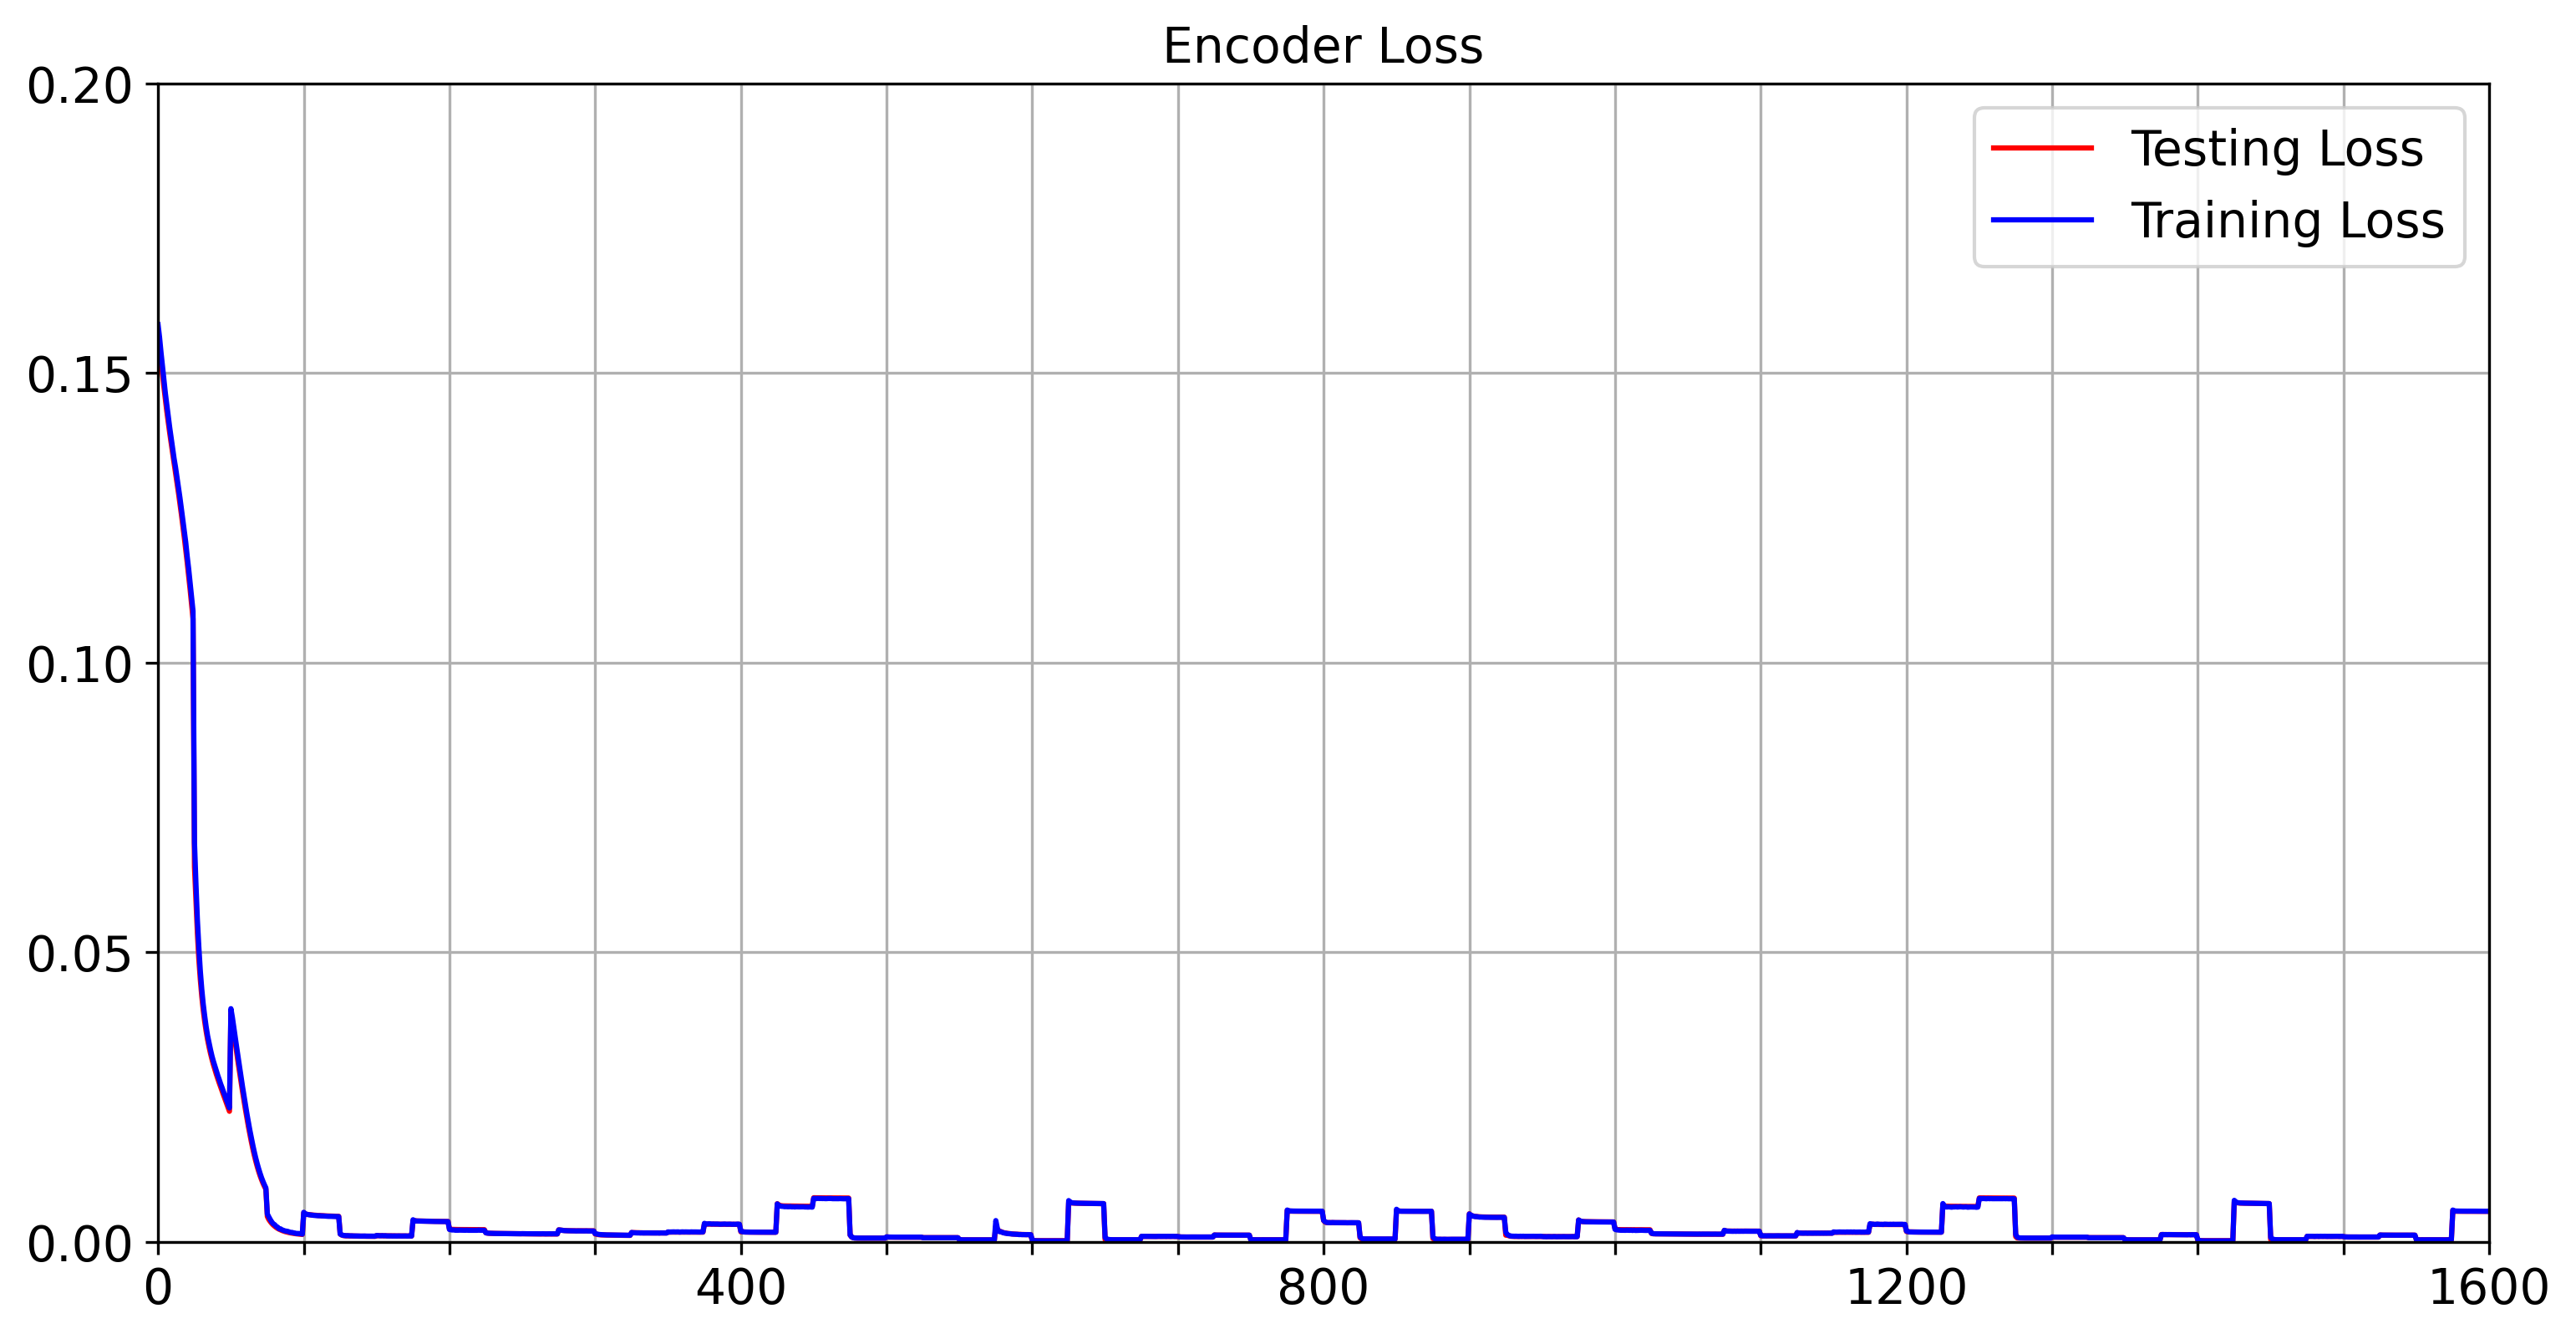

In [ ]:
batchsize=32
graph_loss("Encoder", save_fig=True)

In [ ]:
torch.cuda.empty_cache()

Model Application:

In [ ]:
def apply_model(apply_dataloader, model):

    path = f"{out}/MLP1L.pt"

    # Load the model and the optimizer of the previous run
    saved_model = torch.load(path, weights_only=True)
    model.load_state_dict(saved_model['model_state_dict'])

    frames = []

    with torch.no_grad():
        for video, watermark in apply_dataloader:
            pred = model(video, watermark)

            frames.append(pred)
            del pred

    frames = torch.cat(frames)
    frames_shape = frames.shape
    frames = torch.reshape(frames, (frames_shape[0], 1, frames_shape[-2], frames_shape[-1]))

    del frames_shape

    return frames

In [ ]:
names = ["bluesky", "crosswalk", "crowd1", "dinner", "ducks2", "factory1", "factory2", "field1", "field2", "intotree1", "intotree2", "kayak1", "kayak2", "life2", "life3",
         "market", "oldtown", "parkjoy1", "parkjoy2", "pedestrian1", "riverbed1", "riverbed2", "rush2", "sintel1", "sintel2", "snow", "speedbag1", "speedbag2",
         "sunflower2", "touchdown1", "touchdown2", "wind"]
#names = ["bluesky"]

'names = ["bluesky", "crosswalk", "crowd1", "dinner", "ducks2", "factory1", "factory2", "field1", "field2", "intotree1", "intotree2", "kayak1", "kayak2", "life2", "life3",\n         "market", "oldtown", "parkjoy1", "parkjoy2", "pedestrian1", "riverbed1", "riverbed2", "rush2", "sintel1", "sintel2", "snow", "speedbag1", "speedbag2",\n         "sunflower2", "touchdown1", "touchdown2", "wind"]\n#names = ["bluesky"]'

In [ ]:
#names = ["aspen", "crowd2", "ducks", "life1", "pedestrian2", "rush1", "sintel3", "sunflower1"]

In [ ]:
for name in names:
  curriculum=1
  device="cuda"

  apply_watermark = wm_val
  apply_watermark = apply_watermark.to(device)
  batchsize = 1
  model = Autoencoder().to(device)

  # Continuous training directory
  directory1 = f'0419_{curriculum:02d}_full'

  out = directory1

  in_val = torch.load(f'/content/drive/Shareddrives/thesis_0418 training_val/{name}_val_tensor', weights_only=True)/255

  curriculum = 1

  apply_video = in_val
  apply_video = apply_video.to(device)

  del in_val

  apply_dataset = DeclareDataset(apply_video, apply_watermark)

  del apply_video

  apply_dataloader = DataLoader(apply_dataset, batch_size=batchsize, shuffle=False)

  del apply_dataset

  embedded_video = apply_model(apply_dataloader, model)

  torch.save(embedded_video.detach().clone(), f'{name}_embedded')

  plt.imshow(embedded_video.detach().cpu()[200][0]*255)
  plt.show()

  del apply_dataloader, embedded_video

  del curriculum, device, apply_watermark, batchsize, model, directory1, out

  torch.cuda.empty_cache()

  print(f'{name} done')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.cuda.empty_cache()

In [ ]:
names = ["aspen", "crowd2", "ducks", "life1", "pedestrian2", "rush1", "sintel3", "sunflower1"]

In [ ]:
for name in names:
  curriculum=1
  device="cuda"

  apply_watermark = wm_val
  apply_watermark = apply_watermark.to(device)
  batchsize = 1
  model = Autoencoder().to(device)

  # Continuous training directory
  directory1 = f'0419_{curriculum:02d}_full'

  out = directory1

  #in_val = torch.load(f'testing_val_tensors/{name}_val_tensor', weights_only=True)/255
  in_val = torch.load(f'/content/drive/MyDrive/thesis/testing_val_tensors/{name}_val_tensor', weights_only=True)/255

  curriculum = 1

  apply_video = in_val
  apply_video = apply_video.to(device)

  del in_val

  apply_dataset = DeclareDataset(apply_video, apply_watermark)

  del apply_video

  apply_dataloader = DataLoader(apply_dataset, batch_size=batchsize, shuffle=False)

  del apply_dataset

  embedded_video = apply_model(apply_dataloader, model)

  torch.save(embedded_video.detach().clone(), f'/content/drive/Shareddrives/thesis_0419 merge_tensors/{name}_embedded')

  plt.imshow(embedded_video.detach().cpu()[200][0]*255)
  plt.show()

  del apply_dataloader, embedded_video

  del curriculum, device, apply_watermark, batchsize, model, directory1, out

  torch.cuda.empty_cache()

  print(f'{name} done')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
del curriculum, device, apply_watermark, batchsize, model, directory1, out

NameError: name 'curriculum' is not defined

In [ ]:
#plt.imshow(embedded_video.detach().cpu()[0][0]*255)

In [ ]:
#plt.imshow(in_val[0][0]*255)

In [ ]:
torch.save(embedded_video.detach().clone(), f'{name}_embedded')
torch.save(convolved_video.detach().clone(), f'{name}_convolved')

In [ ]:
torch.cuda.empty_cache()
del apply_model, apply_dataloader, embedded_video, convolved_video, in_val